In [1]:
skip_training = False  # Set this flag to True before validation and submission

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tests
import tools


ModuleNotFoundError: No module named 'einops'

In [1]:
# When running on your own computer, you can specify the data directory by:
root="clothes_dataset"

In [24]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## FashionMNIST dataset

Let us use the FashionMNIST dataset. It consists of 60,000 training images of 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'.

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

trainset = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.77MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.70MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 7.04MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Let us visualize the data.

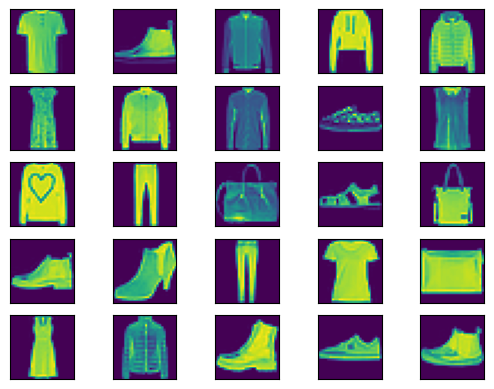

In [17]:
images, labels = next(iter(trainloader))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))

# 1. Simple convolutional network

In the first exercise, your task is to create a convolutional neural network with the architecture inspired by the classical LeNet-5 [(LeCun et al., 1998)](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

The architecture of the convolutional network that you need to create:
* 2d convolutional layer with:
    * one input channel
    * 6 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* 2d convolutional layer with:
    * 16 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* A fully-connected layer with:
    * 120 outputs
    * followed by ReLU
* A fully-connected layer with:
    * 84 outputs
    * followed by ReLU
* A fully-connected layer with 10 outputs and without nonlinearity.

In [18]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1=nn.Conv2d(1,6,5) #one inpu, 6 output #kernel of size 5x5
        self.conv2=nn.Conv2d(6,16,5) 
        self.fc1=nn.Linear(16*4*4,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)

    def forward(self, x):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.

        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        c1=F.relu(self.conv1(x)) 
        s2=F.max_pool2d(c1,(2,2)) #return a (batch_size,6,14,14) tensor
        c3=F.relu(self.conv2(s2))
        s4=F.max_pool2d(c3,(2,2)) #return a tensor of size (batch_size,16,4,4) tensor
        
        s4=torch.flatten(s4,1) #permet de transformer les coucches en 3D en une couche en 1d
        act5=F.relu(self.fc1(s4))
        act6=F.relu(self.fc2(act5))
        output=self.fc3(act6)
        return output

In [19]:
def test_LeNet5_shapes():
    net = LeNet5()

    # Feed a batch of images from the training data to test the network
    with torch.no_grad():
        images, labels = next(iter(trainloader))
        print('Shape of the input tensor:', images.shape)

        y = net(images)
        assert y.shape == torch.Size([trainloader.batch_size, 10]), "Bad shape of y: y.shape={}".format(y.shape)

    print('Success')

test_LeNet5_shapes()

Shape of the input tensor: torch.Size([32, 1, 28, 28])
Success


In [20]:
def test_LeNet5():
    net = LeNet5()

    # get gradients for parameters in forward path
    net.zero_grad()
    x = torch.randn(1, 1, 28, 28)
    outputs = net(x)
    outputs[0,0].backward()

    parameter_shapes = sorted(tuple(p.shape) for p in net.parameters() if p.grad is not None)
    print(parameter_shapes)
    expected = [(6,), (6, 1, 5, 5), (10,), (10, 84), (16,), (16, 6, 5, 5), (84,), (84, 120), (120,), (120, 256)]
    assert parameter_shapes == expected, "Wrong number of training parameters."

    print('Success')

test_LeNet5()

[(6,), (6, 1, 5, 5), (10,), (10, 84), (16,), (16, 6, 5, 5), (84,), (84, 120), (120,), (120, 256)]
Success


# Train the network

In [21]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

### Training loop

Your task is to implement the training loop. The recommended hyperparameters:
* Stochastic Gradient Descent (SGD) optimizer with learning rate 0.001 and momentum 0.9.
* Cross-entropy loss. Note that we did not use softmax nonlinearity in the final layer of our network. Therefore, we need to use a loss function with log_softmax implemented, such as [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).
* Number of epochs: 10. Please use mini-batches produces by `trainloader` defined above.

We recommend you to use function `compute_accuracy()` defined above to track the accuracy during training. The test accuracy should be above 0.87.

In [22]:
# Create network
net = LeNet5()

In [23]:
# Implement the training loop in this cell
if not skip_training:
    n_epochs=10
    criterion=nn.CrossEntropyLoss()
    optim=torch.optim.SGD(params=net.parameters(),momentum=0.9)
    for n in range(n_epochs):
        accuracy=compute_accuracy(net,testloader)
        print(accuracy)
        
        for images,labels in trainloader:
            optim.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs=net(images)
            
            loss=criterion(outputs,labels)
            loss.backward() #compute the gradients
            optim.step() #mets à jour les poids de l'optimiseur
            
    
    print("training_finished")
    accuracy=compute_accuracy(net,testloader)
    print(f'final accuracy : {accuracy}')
            
            
    
    
    


0.1
0.7272
0.7751
0.8087
0.832
0.8494
0.8554
0.8598
0.8625
0.8748
training_finished
final accuracy : 0.8811


In [28]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
torch.save(net.state_dict(),f="modelex1_conv")

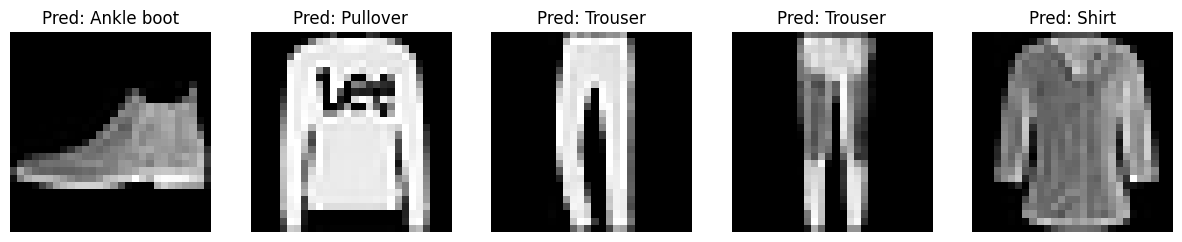

Ground truth:  Ankle boot   Pullover    Trouser    Trouser      Shirt
Predictions:   Ankle boot   Pullover    Trouser    Trouser      Shirt


In [ ]:

# Set the network to evaluation mode
net.eval()

# 1. Grab a batch of data
with torch.no_grad():
    images, labels = next(iter(testloader))
    
    # 2. Compute predictions
    images_dev = images.to(device)
    outputs = net(images_dev)
    _, predicted = torch.max(outputs, 1)

# 3. Plot the first 5 images using Matplotlib
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    # PyTorch tensors are (C, H, W), Matplotlib needs (H, W, C)
    img = images[i].numpy().transpose((1, 2, 0))
    
    # If your images were normalized, you might need to un-normalize them here
    # img = img * std + mean 
    
    axes[i].imshow(img.squeeze(), cmap='gray' if img.shape[2] == 1 else None)
    axes[i].set_title(f"Pred: {classes[predicted[i]]}")
    axes[i].axis('off')

plt.show()

# 4. Print the text summary
print('Ground truth: ', ' '.join('%10s' % classes[labels[j]] for j in range(5)))
print('Predictions:  ', ' '.join('%10s' % classes[predicted[j]] for j in range(5)))

In [30]:
# Compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)
assert accuracy > 0.85, "Poor accuracy {:.3f}".format(accuracy)
print('Success')

Accuracy of the network on the test images: 0.881
Success
